<a href="https://colab.research.google.com/github/starminalush/ml_course_2022/blob/master/lesson8/lesson8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Немного теории

Временной ряд -  это последовательность наблюдений, упорядоченных во времени (или пространстве)

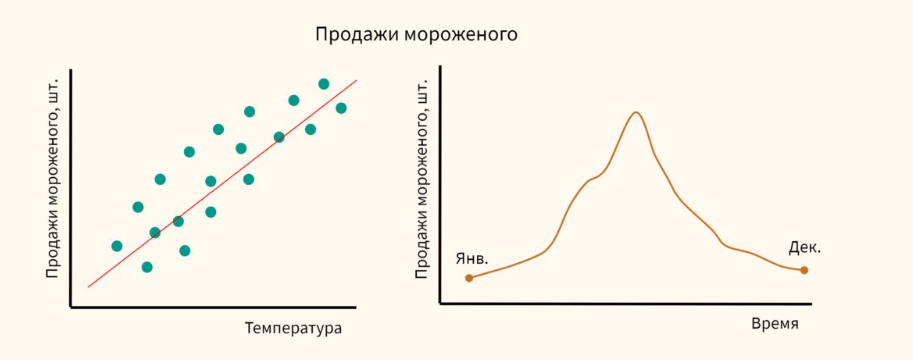

Данные временных рядов можно анализировать для извлечения значимой статистики и других характеристик. Он используется по крайней мере в 4 сценариях:

а) Бизнес-прогнозирование

б) понять прошлое поведение

в) планировать будущее

г) оценить текущее достижение

Нам не нужно применять временные ряды по крайней мере в следующих 2 случаях:

а) Зависимая переменная (у) (которая должна меняться со временем) постоянна. Пример: y=f(x)=4, линия, параллельная оси x(время), всегда будет оставаться неизменной.

б) Зависимая переменная (y) представляет значения, которые можно обозначить как математическую функцию. Уравнение: sin(x), log(x), полиномы и т. д. Таким образом, мы можем напрямую получить значение в какой-то момент, используя саму функцию. Нет необходимости в прогнозировании.

## Импорты

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from prophet import Prophet
from prophet.plot import plot_plotly
import plotly.offline as py
from pyparsing import identbodychars
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)

In [4]:
df = pd.read_csv('AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Будем иметь дело с двумя столбцами, один из которых является временным,в данном случае месяц, а другой - прогнозируемое значение - пассажиры самолетов. Чтобы упростить построение графиков, мы устанавливаем индекс фрейма данных pandas на месяц. Во время построения индекс будет действовать по умолчанию как ось X, и поскольку он имеет только еще 1 столбец, он будет автоматически принят за ось Y.

In [5]:
df['Month'] = pd.to_datetime(df['Month'],infer_datetime_format=True)
indexedDataset = df.set_index(['Month'])
indexedDataset.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Построим график

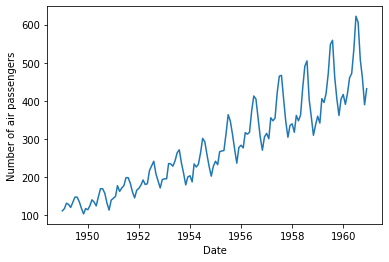

In [6]:
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(indexedDataset)

## Изменение шага временного ряда и сдвиг

#### Изменение шага временного ряда

In [9]:
resample_indexed_Dataset = indexedDataset.resample(rule='AS').mean().head()

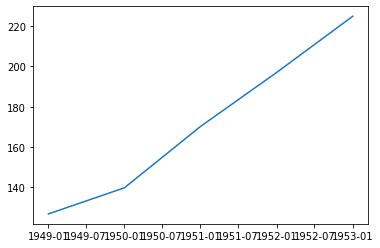

In [10]:
plt.plot(resample_indexed_Dataset)

#### Сдвиг временного ряда

In [11]:
indexedDataset.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [12]:
indexedDataset.shift(-2, axis=0).head()

,#Passengers
Month,
1949-01-01,132.0
1949-02-01,129.0
1949-03-01,121.0
1949-04-01,135.0
1949-05-01,148.0


## Компоненты временного ряда



1.   Тренд - постоянное восходящее и нисходящее движение данных во времени в течение большого периода времени, например, отношение йены к доллару
2.   Сезонность -  циклические изменения уровня ряда с постоянным периодом.
3.   Шум - отличающиеся данные в рандомный момент, которые нельзя прогнозировать.
4.   Цикличность - поведение, которое повторяется на протяжении большого интервала времени. ?



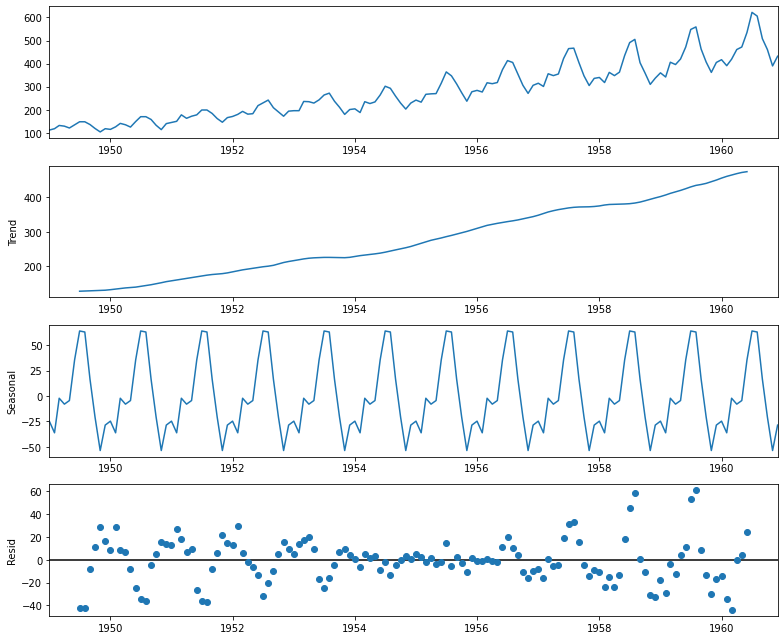

In [13]:
rcParams['figure.figsize'] = 11, 9
 
# применяем функцию к данным о перевозках
decompose = seasonal_decompose(indexedDataset)
decompose.plot()
 
plt.show()

## Что такое стационарность и зачем она нужна

Одномерный временной ряд называется стационарным, если его вероятностные характеристики (параметры случайной величины) постоянны, то есть, отсутствует тренд и сезонность. Временной ряд называется нестационарным, если хотя бы одна из вероятностных характеристик непостоянна, то есть, есть тренд или сезонность

Временной ряд должен быть стационарным по следующим причинам:

а) Если временной ряд ведет себя определенным образом на временном интервале, то существует высокая вероятность того, что на другом интервале она будет вести себя так же, при условии, что временной ряд является стационарным. Это помогает точно прогнозировать.

б) Теории и математические формулы  легче применять для стационарных временных рядов

Способы проверки ряда на стационарность:
1. Rolling Statistics
2. ADCF test

#### RollingStatistics

In [14]:
indexedDataset.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [15]:
indexedDataset.rolling(window=3).mean()

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,120.666667
1949-04-01,126.333333
1949-05-01,127.333333
...,...
1960-08-01,587.666667
1960-09-01,578.666667
1960-10-01,525.000000


In [16]:
rol = indexedDataset.rolling(window=3)
rol

Rolling [window=3,center=False,axis=0,method=single]

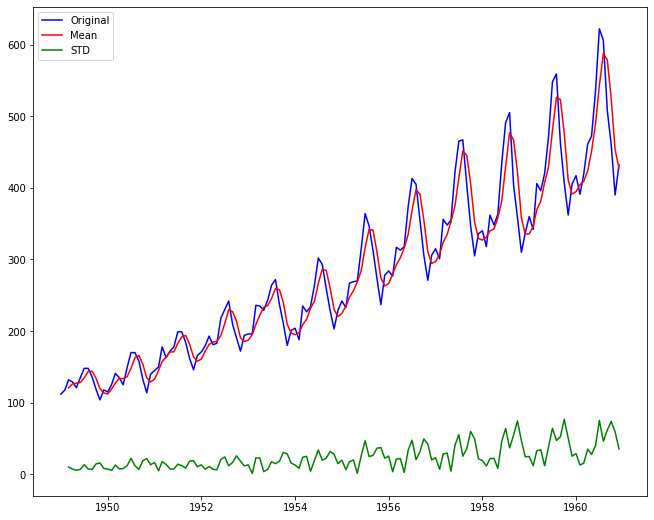

In [17]:
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rol.mean(), color='red', label='Mean')
std = plt.plot(rol.std(), color='green', label='STD')
plt.legend(loc='best')
plt.show()

#### ADCF test

In [18]:
adcf = adfuller(indexedDataset['#Passengers'], autolag='AIC')
adcf

(0.8153688792060472,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.6929308390189)

In [19]:
dfout = pd.Series(adcf[0:4], index=['test statistics', 'p-value', 'lag used', 'number of observation'])
for k,v in adcf[4].items():
  dfout[f'critical value {k}'] = v
print(dfout)               

test statistics            0.815369
p-value                    0.991880
lag used                  13.000000
number of observation    130.000000
critical value 1%         -3.481682
critical value 5%         -2.884042
critical value 10%        -2.578770
dtype: float64


#### Как добиться стационарности?

Есть несколько способов добиться стационарности посредством преобразования данных, например, взять log10, квадрат, квадратный корень, куб, кубический корень, экспоненциальное затухание, сдвиг во времени и так далее...


1. взятие логарифма

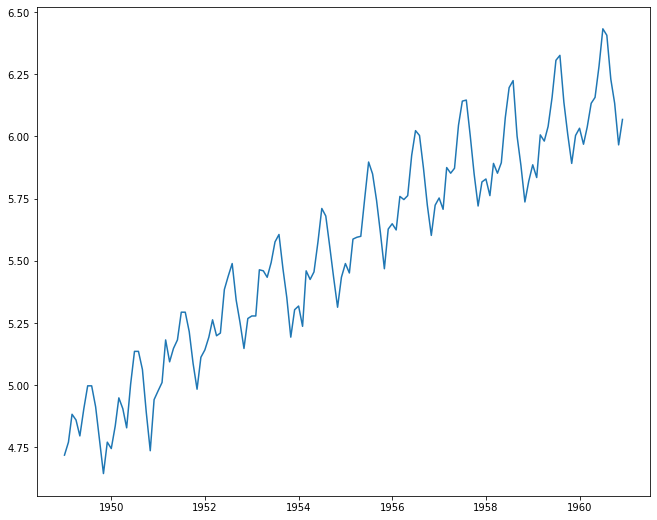

In [20]:
indexed_dataset_log = np.log(indexedDataset)
plt.plot(indexed_dataset_log)

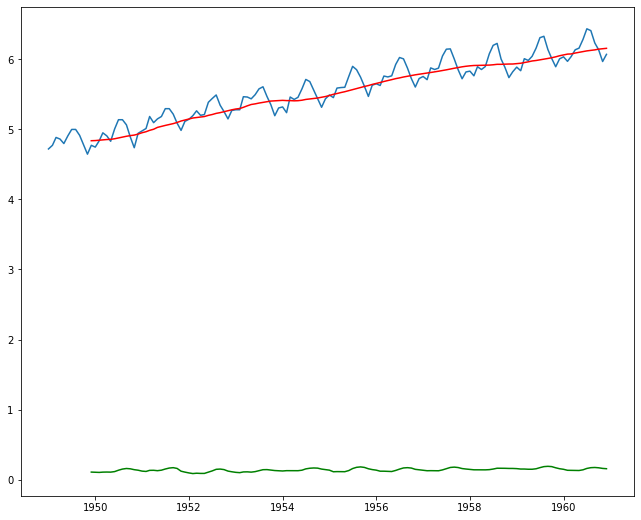

In [21]:
indexed_dataset_log_mean = indexed_dataset_log.rolling(window=12).mean()
indexed_dataset_log_std = indexed_dataset_log.rolling(window=12).std()
plt.plot(indexed_dataset_log)
plt.plot(indexed_dataset_log_mean, color='red')
plt.plot(indexed_dataset_log_std, color='green')

In [22]:
dataset_indexed_without_trend = indexed_dataset_log - indexed_dataset_log_mean
dataset_indexed_without_trend.head(15)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


In [23]:
dataset_indexed_without_trend.dropna(inplace=True)
dataset_indexed_without_trend

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
...,...
1960-08-01,0.282363
1960-09-01,0.098235
1960-10-01,-0.009230


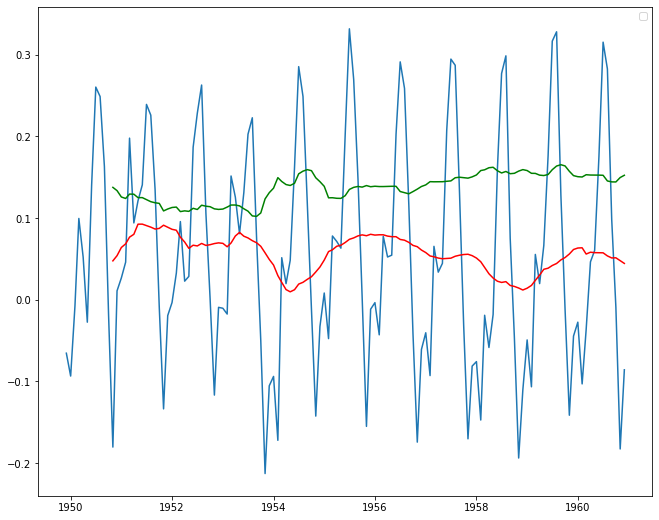

In [24]:
indexed_dataset_log_mean = dataset_indexed_without_trend.rolling(window=12).mean()
indexed_dataset_log_std = dataset_indexed_without_trend.rolling(window=12).std()
plt.plot(dataset_indexed_without_trend)
plt.plot(indexed_dataset_log_mean, color='red')
plt.plot(indexed_dataset_log_std, color='green')
plt.legend(loc='best')

In [25]:
adcf = adfuller(dataset_indexed_without_trend['#Passengers'], autolag='AIC')
dfout = pd.Series(adcf[0:4], index=['test statistics', 'p-value', 'lag used', 'number of observation'])
for k,v in adcf[4].items():
  dfout[f'critical value {k}'] = v
print(dfout)               

test statistics           -3.162908
p-value                    0.022235
lag used                  13.000000
number of observation    119.000000
critical value 1%         -3.486535
critical value 5%         -2.886151
critical value 10%        -2.579896
dtype: float64


2. exponential decay transformation

In [26]:
exponential_decay_trans_dataset = indexed_dataset_log.ewm(halflife=12, min_periods = 0, adjust=True).mean()

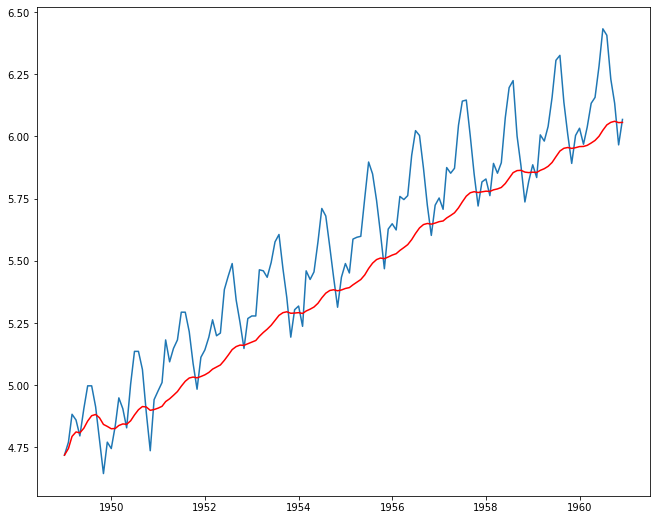

In [27]:
plt.plot(indexed_dataset_log)
plt.plot(exponential_decay_trans_dataset, color='red')

In [28]:
dataset_without_trend = indexed_dataset_log  - exponential_decay_trans_dataset

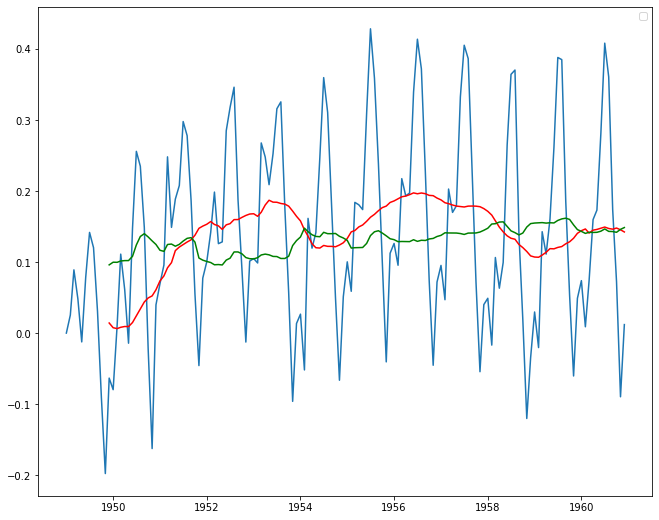

In [29]:
indexed_dataset_log_mean = dataset_without_trend.rolling(window=12).mean()
indexed_dataset_log_std = dataset_without_trend.rolling(window=12).std()
plt.plot(dataset_without_trend)
plt.plot(indexed_dataset_log_mean, color='red')
plt.plot(indexed_dataset_log_std, color='green')
plt.legend(loc='best')


In [30]:
adcf = adfuller(dataset_without_trend['#Passengers'], autolag='AIC')
dfout = pd.Series(adcf[0:4], index=['test statistics', 'p-value', 'lag used', 'number of observation'])
for k,v in adcf[4].items():
  dfout[f'critical value {k}'] = v
print(dfout)               

test statistics           -3.601262
p-value                    0.005737
lag used                  13.000000
number of observation    130.000000
critical value 1%         -3.481682
critical value 5%         -2.884042
critical value 10%        -2.578770
dtype: float64


 3. time shift transformation

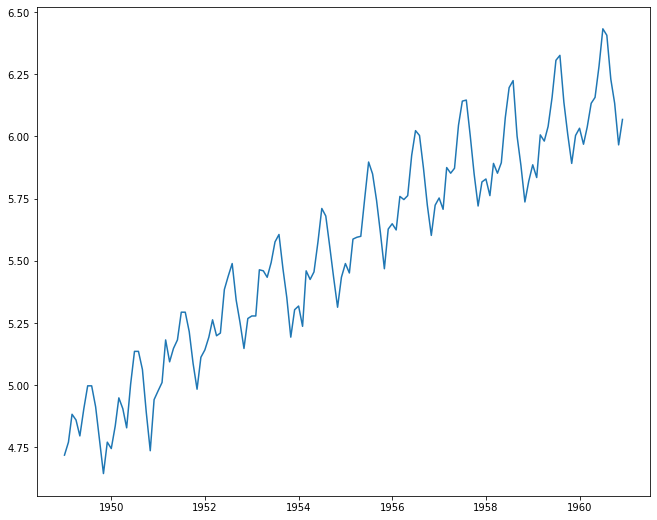

In [31]:
indexed_dataset_log = np.log(indexedDataset)
plt.plot(indexed_dataset_log)

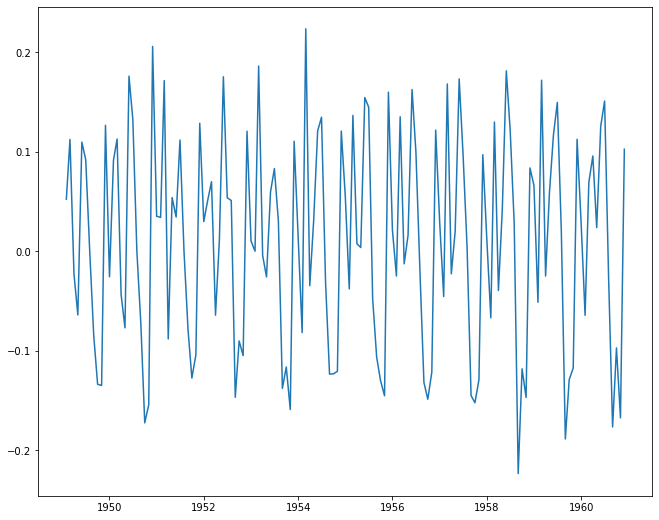

In [32]:
dataset_without_trend_shift = indexed_dataset_log - indexed_dataset_log.shift()
plt.plot(dataset_without_trend_shift)

In [33]:
dataset_without_trend_shift.dropna(inplace=True)

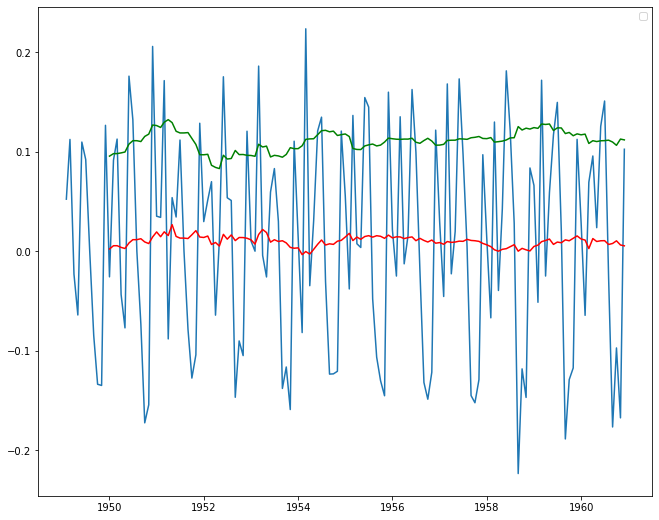

In [34]:
indexed_dataset_log_mean = dataset_without_trend_shift.rolling(window=12).mean()
indexed_dataset_log_std = dataset_without_trend_shift.rolling(window=12).std()
plt.plot(dataset_without_trend_shift)
plt.plot(indexed_dataset_log_mean, color='red')
plt.plot(indexed_dataset_log_std, color='green')
plt.legend(loc='best')


In [35]:
adcf = adfuller(dataset_without_trend_shift['#Passengers'], autolag='AIC')
dfout = pd.Series(adcf[0:4], index=['test statistics', 'p-value', 'lag used', 'number of observation'])
for k,v in adcf[4].items():
  dfout[f'critical value {k}'] = v
print(dfout)   

test statistics           -2.717131
p-value                    0.071121
lag used                  14.000000
number of observation    128.000000
critical value 1%         -3.482501
critical value 5%         -2.884398
critical value 10%        -2.578960
dtype: float64


p-value = 0.05

p-value original = 0.99

np.log(dataset) - np.log(dataset).rolling(window=12).mean() = 0.02

np.log(dataset)  - ewc(np.log(dataset)) = 0.005 ## dataset_without_trend

np.log(dataset) - time shift(np.log(dataset))  = 0.07

### Кореляция и автокореляция

In [36]:
indexedDataset.head(10)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


lag = [1, 3]

In [37]:
# сдвигаем ряд на 1
data = indexedDataset['#Passengers']
lag_1 = data[1:]
lag_1.head()

Month
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
Name: #Passengers, dtype: int64

In [38]:
np.round(np.corrcoef(data[:-1], lag_1)[0, 1], 2)

0.96

Text(0, 0.5, 'lag_1')

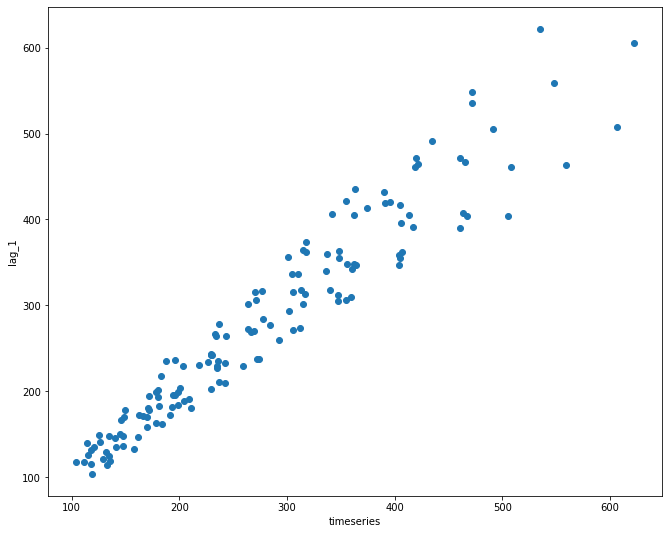

In [39]:
plt.scatter(data[:-1], lag_1)
plt.xlabel('timeseries')
plt.ylabel('lag_1')

Корреляция показывает силу взаимосвязи двух переменных.
Автокорреляция также показывает степень взаимосвязи в диапазоне от –1 до 1, но только не двух переменных, а одной и той же переменной в разные моменты времени.

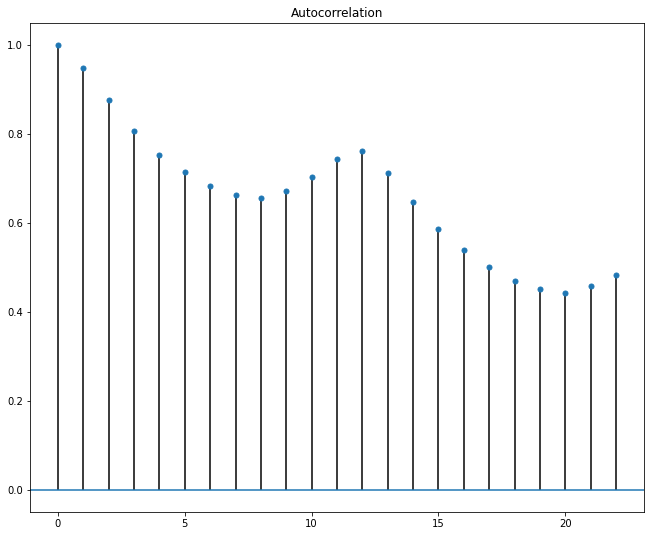

In [40]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data, alpha=None)
plt.show()

### Модели

#### Экспоненциальное сглаживание

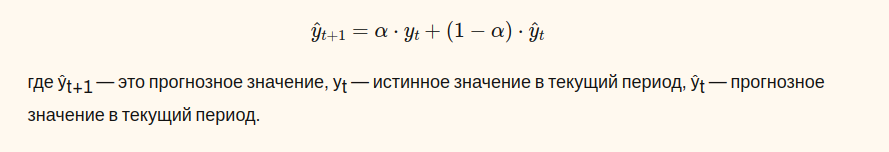

прогнозы со второго наблюдения + 1

In [41]:
alpha = 0.02

exp_smoothing = [dataset_without_trend['#Passengers'][0]]
for i in range(1, len(dataset_without_trend)):
  exp_smoothing.append(alpha*dataset_without_trend['#Passengers'][i] + (1-alpha) * exp_smoothing[i- 1])

In [42]:
dataset_without_trend.tail()

,#Passengers
Month,
1960-08-01,0.360435
1960-09-01,0.173704
1960-10-01,0.072319
1960-11-01,-0.089603
1960-12-01,0.011964


In [43]:
dataset_without_trend['exp_smoothing'] = exp_smoothing
dataset_without_trend.head()

,#Passengers,exp_smoothing
Month,,
1949-01-01,0.000000,0.000000
1949-02-01,0.025339,0.000507
1949-03-01,0.088967,0.002276
1949-04-01,0.048028,0.003191
1949-05-01,-0.012415,0.002879


In [44]:
from datetime import timedelta
last_date = dataset_without_trend.iloc[[-1]].index

last_date = last_date + timedelta(days=30)

new_indexed = dataset_without_trend.append(pd.DataFrame(index=last_date))

new_indexed.head()

,#Passengers,exp_smoothing
Month,,
1949-01-01,0.000000,0.000000
1949-02-01,0.025339,0.000507
1949-03-01,0.088967,0.002276
1949-04-01,0.048028,0.003191
1949-05-01,-0.012415,0.002879


In [45]:
new_indexed['exp_smoothing'] = new_indexed['exp_smoothing'].shift()
new_indexed.head()

,#Passengers,exp_smoothing
Month,,
1949-01-01,0.000000,NaN
1949-02-01,0.025339,0.000000
1949-03-01,0.088967,0.000507
1949-04-01,0.048028,0.002276
1949-05-01,-0.012415,0.003191


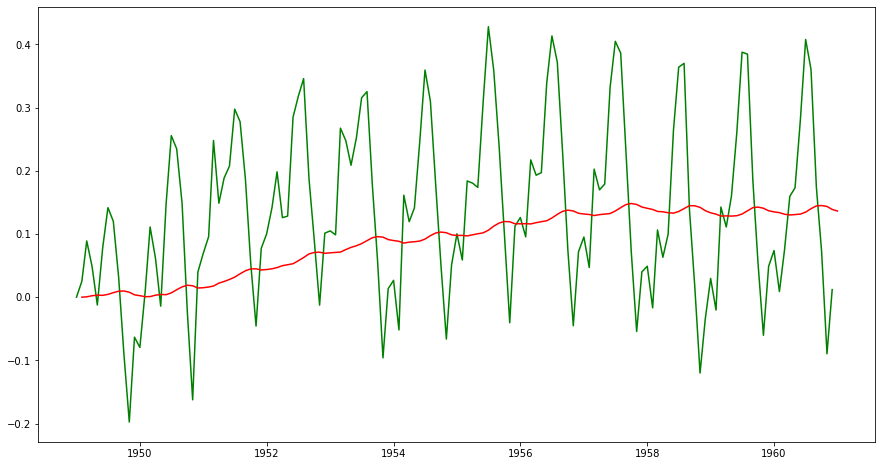

In [46]:
plt.figure(figsize=(15,8))
plt.plot(new_indexed['#Passengers'], label='etalon', color='green')
plt.plot(new_indexed['exp_smoothing'], label='predicted', color='red')
plt.show()

#### ARIMA

Авторегрессионное интегрированное скользящее среднее (autoregressive integrated moving average, ARIMA) является обобщением модели авторегрессионного скользящего среднего. Эти модели используются при работе с временными рядами для более глубокого понимания данных или предсказания будущих точек ряда. Обычно модель упоминается, как ARIMA(p,d,q), где p,d и q — целые неотрицательные числа, характеризующие порядок для частей модели (соответственно авторегрессионной, интегрированной и скользящего среднего).

семейство ARMA: AR - авторегрессия, MA - модель скользящего среднего

семейство:

1.   ARMA - не умеет работать с рядами, в которых есть тренд и сезонность
2.   ARIMA - умеет работать с трендами
3.   SARIMA - учитывает сезонность
4.   SARIMAX - учитывает внешние данные



https://www.statsmodels.org/0.8.0/generated/statsmodels.tsa.arima_model.ARIMA.html

Plotting ARIMA model


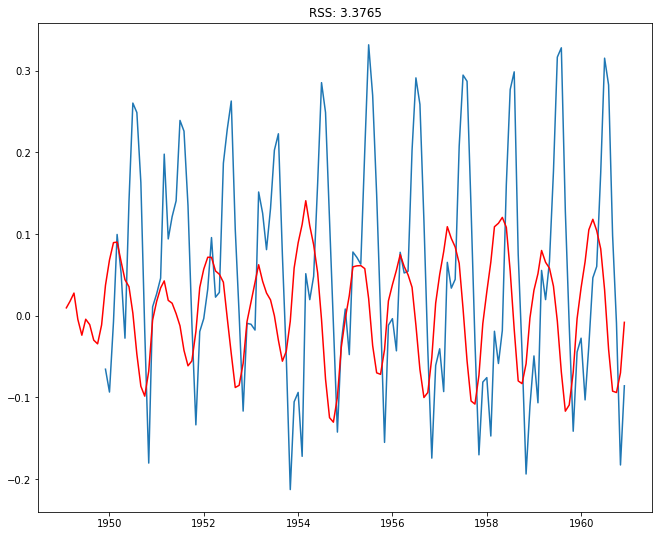

In [48]:
model = ARIMA(indexed_dataset_log, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(dataset_indexed_without_trend)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum(((results_ARIMA.fittedvalues - dataset_indexed_without_trend['#Passengers']).fillna(0))**2))
print('Plotting ARIMA model')

In [62]:
train = indexed_dataset_log[:'1957-12']
 
test = indexed_dataset_log['1958-01':]

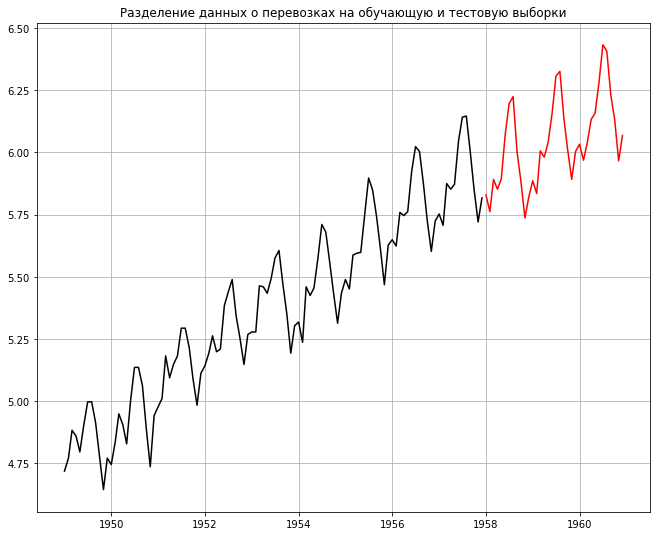

In [63]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
 
plt.title('Разделение данных о перевозках на обучающую и тестовую выборки')
 
plt.grid()
 
plt.show()

In [69]:
model = ARIMA(train, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)

In [70]:
train.shape

(108, 1)

In [71]:
test.shape

(36, 1)

выведем предикты до января 1960

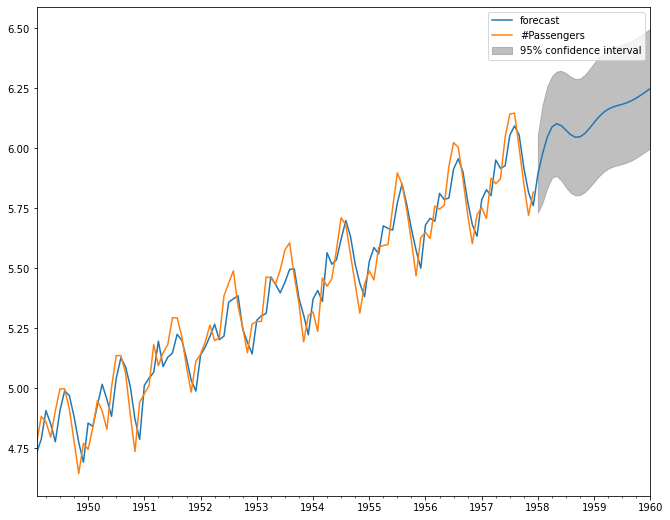

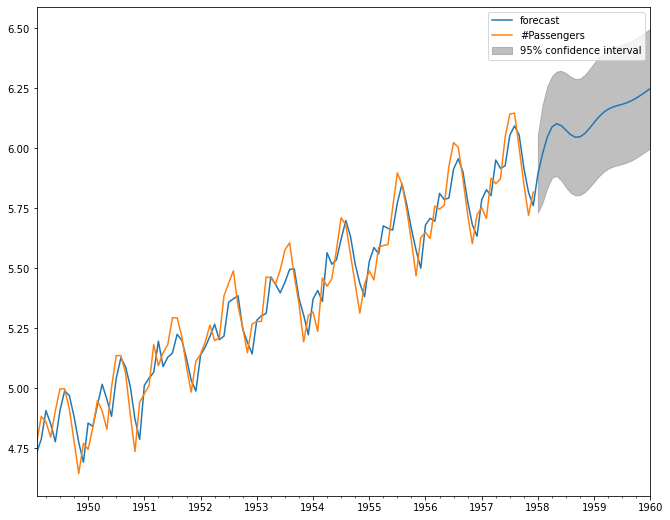

In [78]:
from datetime import datetime
results_ARIMA.plot_predict(end = datetime.strptime('1960-01-01', "%Y-%m-%d"))